In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import time
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
import scipy
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Setting

In [0]:
def setting(n, p, p1, noise=1,npseed=0):
    np.random.seed(npseed)
    T=np.empty((n, p-p1))

    for i in range(n):
        T[i,:] = np.random.normal(0,1, size = (1, p-p1))

    beta1 = np.ones(p1)
    # beta2 = torch.cat((torch.ones(1), torch.zeros(p-p1-1)), dim=0)
    beta2 = np.ones(p-p1)
    # beta=np.concatenate((beta1,beta2),axis=0)
    # print
    Z = 50*np.sum(np.sin(T), axis=1).reshape(n, 1) + np.random.normal(0, noise, size = (n, 1))
    g_T = np.cosh(T)
    y = np.matmul(Z,beta1).reshape(n, 1) + \
    np.sum(g_T, axis=1).reshape(n, 1) + np.random.normal(0, noise, size = (n, 1))
    X = np.concatenate((Z, T), axis = 1)
    return y, X, beta1

def newset(y, Z, T):
    new_y = torch.tensor(np.concatenate((y, Z), axis=1)).float()
    new_data = torch.tensor(T).float()
    return new_y, new_data

## models

In [0]:
"""The :mod:`sklearn.kernel_regressor` module implements the Kernel Regressor.
"""
# Author: Jan Hendrik Metzen <janmetzen@mailbox.de>
#
# License: BSD 3 clause

import numpy as np

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin


class KernelRegression(BaseEstimator, RegressorMixin):
    """Nadaraya-Watson kernel regression with automatic bandwidth selection.

    This implements Nadaraya-Watson kernel regression with (optional) automatic
    bandwith selection of the kernel via leave-one-out cross-validation. Kernel
    regression is a simple non-parametric kernelized technique for learning
    a non-linear relationship between input variable(s) and a target variable.

    Parameters
    ----------
    kernel : string or callable, default="rbf"
        Kernel map to be approximated. A callable should accept two arguments
        and the keyword arguments passed to this object as kernel_params, and
        should return a floating point number.

    gamma : float, default=None
        Gamma parameter for the RBF ("bandwidth"), polynomial,
        exponential chi2 and sigmoid kernels. Interpretation of the default
        value is left to the kernel; see the documentation for
        sklearn.metrics.pairwise. Ignored by other kernels. If a sequence of
        values is given, one of these values is selected which minimizes
        the mean-squared-error of leave-one-out cross-validation.

    See also
    --------

    sklearn.metrics.pairwise.kernel_metrics : List of built-in kernels.
    """

    def __init__(self, kernel="rbf", gamma=None):
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y):
        """Fit the model

        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The training input samples.

        y : array-like, shape = [n_samples, m]
            The target values

        Returns
        -------
        self : object
            Returns self.
        """
        self.X = X
        self.y = y

        if hasattr(self.gamma, "__iter__"):
            self.gamma = self._optimize_gamma(self.gamma)

        return self

    def predict(self, X_test):
        """Predict target values for X_test, size m*n_features.

        Parameters
        ----------
        X_test : array-like of shape = [n_te_samples, n_features]
            The input samples.

        Returns
        -------
        y : array of shape = [n_te_samples, m]
            The predicted target value.
        """
        K = pairwise_kernels(self.X, X_test, metric=self.kernel, gamma=self.gamma)
        # K.shape=[n_tr_samples, n_te_samples]
        # self.X.shape=[n_tr_samples, n_features]
        # self.y.shape=[n_tr_samples, m]
        if self.y.ndim==1:
            ncol=1
        else:
            ncol=self.y.shape[1]
        numerator=(np.transpose(self.y).dot(K)).reshape(ncol,K.shape[1])
        return np.transpose(numerator / K.sum(axis=0))

    def _optimize_gamma(self, gamma_values):
        # Select specific value of gamma from the range of given gamma_values
        # by minimizing mean-squared error in leave-one-out cross validation
        mse = np.empty_like(gamma_values, dtype=np.float)
        for i, gamma in enumerate(gamma_values):
            K = pairwise_kernels(self.X, self.X, metric=self.kernel,
                                 gamma=gamma)
            np.fill_diagonal(K, 0)  # leave-one-out
            Ky = K * self.y[:, np.newaxis]
            y_pred = Ky.sum(axis=0) / K.sum(axis=0)
            mse[i] = ((y_pred - self.y) ** 2).mean()

        return gamma_values[np.nanargmin(mse)]

In [0]:
def PLMNN(y_train, Z_train, T_train, y_test, Z_test, T_test):
  yZ_train, T_train = newset(y_train, Z_train, T_train)
  yZ_test, T_test = newset(y_test, Z_test, T_test)


  max_epoch = 10
  lr = 1e-3
  D_in, H, D_out = p-p1, 10000, p1+1
  batch_size = 128

  Train_dataset = TensorDataset(T_train, yZ_train)
  trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)
  Test_dataset = TensorDataset(T_test, yZ_test)
  testloader = DataLoader(dataset=Test_dataset, batch_size=batch_size, shuffle=True)

  model = nn.Sequential(
      nn.Linear(D_in, H),
      nn.ReLU(),
      nn.Linear(H, D_out),
  )

  optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=2)
  criterion = nn.MSELoss()
  old_val_error=1e12
  patience=0

  start_time = time.time()
  for epoch in range(max_epoch):
    for batch_T, batch_yZ in trainloader:
      optimizer.zero_grad()
      batch_yZ_pred = model(batch_T)
      batch_loss = criterion(batch_yZ_pred, batch_yZ)
      # print(epoch+1, '---', batch_loss)
      batch_loss.backward()
      optimizer.step()
    with torch.no_grad():
      yZ_pred = model(T_test)
      val_loss = criterion(yZ_pred, yZ_test)
      print(epoch+1, '---', val_loss)

    #early stopping
    if val_loss.item()<old_val_error:
      old_val_error=val_loss.item()
      patience=0
    else:
      patience+=1
    if patience == 1:
      print('Break at epoch:', epoch)
      break

  model.eval()
  whole_pred=model(T_train).cpu().detach().numpy()
  mean_conditional_y_tr=whole_pred[:,0].reshape(-1,1)
  mean_conditional_Z_tr=whole_pred[:,1].reshape(-1,1)
  whole_pred_te=model(T_test).cpu().detach().numpy()
  mean_conditional_y_te=whole_pred_te[:,0].reshape(-1,1)
  mean_conditional_Z_te=whole_pred_te[:,1].reshape(-1,1)

  return mean_conditional_y_tr, mean_conditional_Z_tr,mean_conditional_y_te, mean_conditional_Z_te

In [0]:
def POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml, cov_alpha=0.05):
  # np.random.seed(npseed)
  if ml == 'PLMNN':
    ml_pred_y, ml_pred_Z,ml_pred_y_val, ml_pred_Z_val = \
    PLMNN(y_train, Z_train, T_train, y_val, Z_val, T_val)

  else: 
    if ml == 'Kernel':
      ml_y = KernelRegression() 
      ml_Z = KernelRegression() 

    elif ml == 'Lasso':
      ml_y = Lasso(alpha = 1)  #
      ml_Z = Lasso(alpha = 1)  #, fit_intercept = False

    elif ml == 'Regression tree':
      ml_y = DecisionTreeRegressor(max_depth=2) #random_state=0
      ml_Z = DecisionTreeRegressor(max_depth=2) #random_state=0

    elif ml == 'Random forest':
      ml_y = RandomForestRegressor(max_depth=2) #max_depth=2, random_state=0,n_estimators=50
      ml_Z = RandomForestRegressor(max_depth=2) #max_depth=2, random_state=0,n_estimators=50

    else:
      print('Wrong ML name!')

    ml_y.fit(T_train, y_train)
    ml_pred_y = ml_y.predict(T_train).reshape(-1,1)  #T_test
    ml_pred_y_val = ml_y.predict(T_val).reshape(-1,1)  #T_test

    ml_Z.fit(T_train, Z_train)
    ml_pred_Z = ml_Z.predict(T_train).reshape(-1,1) #T_test
    ml_pred_Z_val = ml_Z.predict(T_val).reshape(-1,1) #T_test

  # plt.scatter(Z_train-ml_pred_Z,y_train-ml_pred_y);plt.show()
  # OLS
  ols_ml = sm.OLS(y_val-ml_pred_y_val, Z_val-ml_pred_Z_val).fit()
  cov_int = ols_ml.conf_int(alpha=cov_alpha,cols=None)[0]
  temp_beta = ols_ml.params
  temp_y_pred = (Z_train-ml_pred_Z).dot(temp_beta.reshape(-1,1))+ml_pred_y
  temp_y_pred_val = (Z_val-ml_pred_Z_val).dot(temp_beta.reshape(-1,1))+ml_pred_y_val
  # temp_y_pred = ols_ml.predict((Z_train-ml_pred_Z).flatten()).reshape(-1,1)+ml_pred_y
  # temp_y_pred_te = ols_ml.predict((Z_test-ml_pred_Z_val).flatten()).reshape(-1,1)+ml_pred_y_val
  temp_count=[(beta1<cov_int[1]) and (beta1>cov_int[0])]
  # plt.scatter(y_test.flatten(),temp_y_pred_val);plt.show()
  # print(ml,temp_beta,cov_int)
  return temp_beta, np.mean((temp_y_pred-y_train)**2),np.mean((temp_y_pred_val-y_val)**2), np.mean(temp_count)

## simulation

In [0]:
import warnings
warnings.filterwarnings("ignore")
Nrun, split_size, sigma, n, p, p1, kfold=50, 0.2, 1, 10000, 11, 1, 5
ymse_plm,ymse_plm_te, betamse_plm, cov_plm, time_plm = 0, 0, 0, 0, 0
ymse_nw,ymse_nw_te, betamse_nw, cov_nw, time_nw = 0, 0, 0, 0,0 # ymse is the mse of ytrain_pred, not ytest_pred
ymse_lasso,ymse_lasso_te, betamse_lasso, cov_lasso, time_lasso = 0, 0, 0, 0, 0
ymse_rt,ymse_rt_te, betamse_rt, cov_rt, time_rt = 0, 0, 0, 0, 0
ymse_rf,ymse_rf_te, betamse_rf, cov_rf, time_rf = 0, 0, 0, 0, 0
for i in range(Nrun):
  torch.manual_seed(i)
  np.random.seed(i)
  y, X, beta1 = setting(n=n, p=p, p1=p1, noise=sigma, npseed=i)

  # data spliting for non-kfold ml: PLMNN, Kernel
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)
  Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
  Z_test, T_test = X_test[:, 0].reshape((-1,1)),  X_test[:, 1:]
  # PLMNN
  start_time = time.time()
  temp_beta_plm, temp_ymse_plm,temp_ymse_plm_te, temp_cov_plm = \
  POAndInf(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='PLMNN')

  ymse_plm += temp_ymse_plm/Nrun
  ymse_plm_te += temp_ymse_plm_te/Nrun
  betamse_plm += ((temp_beta_plm-beta1)**2)/Nrun
  cov_plm += temp_cov_plm/Nrun
  time_plm += (time.time() - start_time)/Nrun

  # Kernel
  start_time = time.time()
  temp_beta_nw, temp_ymse_nw,temp_ymse_nw_te, temp_cov_nw = \
  POAndInf(y_train, Z_train, T_train, y_test, Z_test, T_test, ml='Kernel')

  ymse_nw += temp_ymse_nw/Nrun
  ymse_nw_te += temp_ymse_nw_te/Nrun
  betamse_nw += ((temp_beta_nw-beta1)**2)/Nrun
  cov_nw += temp_cov_nw/Nrun
  time_nw += (time.time() - start_time)/Nrun

  # ml with kfold: Lasso, regression tree, random forest
  kf = KFold(n_splits=kfold)
  kfold_beta_lasso, kfold_ymse_lasso,kfold_ymse_lasso_te, kfold_cov_lasso = 0, 0, 0, 0
  kfold_beta_rt, kfold_ymse_rt,kfold_ymse_rt_te, kfold_cov_rt = 0, 0, 0, 0
  kfold_beta_rf, kfold_ymse_rf,kfold_ymse_rf_te, kfold_cov_rf = 0, 0, 0, 0


  for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
    Z_val, T_val = X_val[:, 0].reshape((-1,1)),  X_val[:, 1:]

    # Lasso
    start_time = time.time()
    temp_beta_lasso, temp_ymse_lasso,temp_ymse_lasso_te, temp_cov_lasso = \
    POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml='Lasso')
    # print(np.mean((T_test.dot(temp_beta_lasso)-T_test.dot(beta1))**2))
    kfold_beta_lasso += temp_beta_lasso/kfold
    kfold_ymse_lasso += temp_ymse_lasso/kfold
    kfold_ymse_lasso_te += temp_ymse_lasso_te/kfold
    kfold_cov_lasso += temp_cov_lasso/kfold
    time_lasso += (time.time() - start_time)/kfold/Nrun

    # Regression tree
    start_time = time.time()
    temp_beta_rt, temp_ymse_rt,temp_ymse_rt_te, temp_cov_rt = \
    POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml='Regression tree')

    kfold_beta_rt += temp_beta_rt/kfold
    kfold_ymse_rt += temp_ymse_rt/kfold
    kfold_ymse_rt_te += temp_ymse_rt_te/kfold
    kfold_cov_rt += temp_cov_rt/kfold
    time_rt += (time.time() - start_time)/kfold/Nrun

    # Random forest
    start_time = time.time()
    temp_beta_rf, temp_ymse_rf,temp_ymse_rf_te, temp_cov_rf = \
    POAndInf(y_train, Z_train, T_train, y_val, Z_val, T_val, ml='Random forest')

    kfold_beta_rf += temp_beta_rf/kfold
    kfold_ymse_rf += temp_ymse_rf/kfold
    kfold_ymse_rf_te += temp_ymse_rf_te/kfold
    kfold_cov_rf += temp_cov_rf/kfold
    time_rf += (time.time() - start_time)/kfold/Nrun

  ymse_lasso += kfold_ymse_lasso/Nrun
  ymse_lasso_te += kfold_ymse_lasso_te/Nrun
  betamse_lasso += ((kfold_beta_lasso-beta1)**2)/Nrun
  cov_lasso += kfold_cov_lasso/Nrun

  ymse_rt += kfold_ymse_rt/Nrun
  ymse_rt_te += kfold_ymse_rt_te/Nrun
  betamse_rt += ((kfold_beta_rt-beta1)**2)/Nrun
  cov_rt += kfold_cov_rt/Nrun

  ymse_rf += kfold_ymse_rf/Nrun
  ymse_rf_te += kfold_ymse_rf_te/Nrun
  betamse_rf += ((kfold_beta_rf-beta1)**2)/Nrun
  cov_rf += kfold_cov_rf/Nrun


1 --- tensor(2345.4141)
2 --- tensor(1626.0774)
3 --- tensor(1612.7853)
4 --- tensor(1601.3025)
5 --- tensor(1605.7848)
Break at epoch: 4
1 --- tensor(2513.2246)
2 --- tensor(1720.9446)
3 --- tensor(1717.2889)
4 --- tensor(1702.2279)
5 --- tensor(1700.5620)
6 --- tensor(1741.9336)
Break at epoch: 5
1 --- tensor(2383.2087)
2 --- tensor(1629.2140)
3 --- tensor(1596.7893)
4 --- tensor(1577.4105)
5 --- tensor(1587.9821)
Break at epoch: 4
1 --- tensor(2377.7227)
2 --- tensor(1561.1758)
3 --- tensor(1547.2113)
4 --- tensor(1541.9032)
5 --- tensor(1551.3009)
Break at epoch: 4
1 --- tensor(2411.4373)
2 --- tensor(1609.0168)
3 --- tensor(1566.5731)
4 --- tensor(1573.2144)
Break at epoch: 3
1 --- tensor(2409.0295)
2 --- tensor(1651.9946)
3 --- tensor(1616.1637)
4 --- tensor(1623.9503)
Break at epoch: 3
1 --- tensor(2603.7793)
2 --- tensor(1762.6715)
3 --- tensor(1740.1663)
4 --- tensor(1732.5155)
5 --- tensor(1711.9550)
6 --- tensor(1708.7426)
7 --- tensor(1745.0765)
Break at epoch: 6
1 --- tens

## results

In [0]:
print(ymse_plm,ymse_plm_te, betamse_plm, cov_plm, time_plm)

10.481300786748152 10.361516669429562 [1.58744956e-05] 0.6800000000000003 4.1475948095321655


In [0]:
print(ymse_nw,ymse_nw_te, betamse_nw, cov_nw, time_nw)

16.333077920432828 16.08327585537468 [1.07896968e-06] 0.9600000000000005 5.052410707473756


In [0]:
print(ymse_lasso,ymse_lasso_te, betamse_lasso, cov_lasso, time_lasso)

15.794080184766283 15.792788509938893 [5.9617738e-06] 0.6080000000000004 0.006558692932128906


In [0]:
print(ymse_rt,ymse_rt_te, betamse_rt, cov_rt, time_rt)

335.9982564668021 342.6750224638652 [0.00065145] 0.6480000000000005 0.05927939796447756


In [0]:
print(ymse_rf,ymse_rf_te, betamse_rf, cov_rf, time_rf)

44.002462645482396 44.87210054688403 [5.76937504e-06] 0.6400000000000003 2.7211635484695424


# NTK converges exponentially fast

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 5000
lr = 1e-2
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

Streaming output truncated to the last 5000 lines.
1 6780.297685857934 7240.464280522945
2 4494.3358658418865 5656.642862395354
3 5943.451519690478 10096.862701766531
4 40984.09650841792 50230.28787707618
5 10059.508146270891 11856.97414420422
6 8061.257326962055 9551.12642345201
7 7298.67131533836 8930.844019907368
8 6874.210728659722 8513.723021032789
9 6559.6795604484905 8152.051326139825
10 6226.272508368741 7747.584581171969
11 5730.599543053712 7114.974253923707
12 4809.655811953056 5889.728961263936
13 3339.766206570916 3877.1862645447686
14 2087.7809208539497 2203.2278631372
15 1608.6106065364343 1542.707374738545
16 1649.2620754507507 1644.2838131920644
17 4108.1744695719135 4206.050025997723
18 21255.781785440304 22141.892275950926
19 9982.373407501398 11851.581468673634
20 8411.951966028639 9194.300312056701
21 7055.206792369671 8094.904992311358
22 5953.719693944083 7162.786309569983
23 5318.49501695931 6468.437292007949
24 4454.068314755994 5306.3496803796515
25 3090.33932

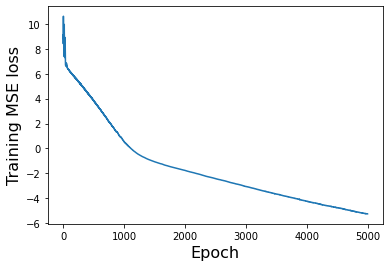

In [0]:
plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training MSE loss',fontsize=16);
plt.savefig('NTK loss.pdf');plt.show()

### other activation

Streaming output truncated to the last 5000 lines.
45001 0.14467614833186496 0.14444092250054338
45002 0.14466925591552493 0.14443541878509422
45003 0.14466246085740303 0.14442695075432754
45004 0.14465405995762254 0.14441954657170716
45005 0.14464763850181053 0.14441309368522742
45006 0.14464105786365103 0.1444054686314313
45007 0.14463384607392207 0.14439815181044616
45008 0.14462658502856882 0.14439229066983184
45009 0.1446189630514841 0.14438297558190663
45010 0.14461071735632566 0.14437734914588746
45011 0.1446043903404971 0.14436932409484585
45012 0.14459642857183427 0.14436255214337498
45013 0.14458915005413936 0.14435433141149256
45014 0.14458272128903435 0.14434857806183546
45015 0.14457373603152124 0.1443395315591628
45016 0.14456590066574135 0.14433368843184588
45017 0.14455919389338043 0.14432704138752203
45018 0.14455258334691376 0.14431761395569226
45019 0.14454505517112495 0.14431192013486896
45020 0.14453652358402003 0.14430345265642897
45021 0.1445318359912989 0.144296

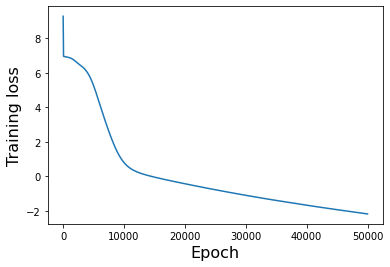

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 50000
lr = 1e-3
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.Tanh(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training loss',fontsize=16);
plt.savefig('tanh NTK loss.pdf');plt.show()

Streaming output truncated to the last 5000 lines.
15001 0.19325185535757375 0.20076416715685094
15002 0.1932203060474939 0.2007358653175964
15003 0.193190424866291 0.2007055203184431
15004 0.1931635819368844 0.200674660790832
15005 0.19313513387822542 0.20064390034125928
15006 0.19310418607710425 0.20061679924794798
15007 0.19307702341243962 0.20058494340860136
15008 0.19304832027600838 0.20055488049561032
15009 0.1930198767344042 0.20052385260986413
15010 0.19299040860119418 0.20049480012680332
15011 0.19295960504196535 0.20046449555120754
15012 0.19293151577206558 0.20043520196321254
15013 0.1929029015309495 0.20040347649041268
15014 0.19287242878710462 0.20037421657091703
15015 0.1928448110114098 0.20034434177970753
15016 0.192815964690965 0.2003152683133258
15017 0.19278863607852845 0.20028196077398774
15018 0.1927564832300113 0.20025353340665794
15019 0.19272817695624056 0.20022474190572492
15020 0.19270040263911753 0.20019389883093763
15021 0.19267406427843048 0.2001629335857830

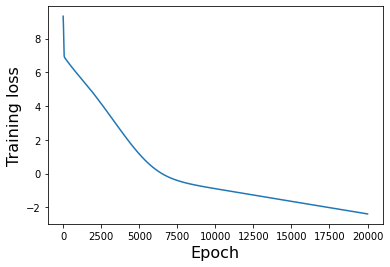

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 20000
lr = 1e-3
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.LeakyReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training loss',fontsize=16);
plt.savefig('Leaky NTK loss.pdf');plt.show()

## other optimizer

Streaming output truncated to the last 5000 lines.
1 11328.583110072032 11565.572102230599
2 11276.33044704073 11504.880020602573
3 11223.575200458607 11444.145169141608
4 11170.079792956736 11383.091760941898
5 11115.621943799772 11321.455640961272
6 11059.994597388422 11258.990989176975
7 11003.007152152006 11195.471697313447
8 10944.487183871595 11130.694403847336
9 10884.281298078049 11064.478689032156
10 10822.246925651281 10996.653892834456
11 10758.253766200936 10927.068986674181
12 10692.186897451224 10855.58979157559
13 10623.938846335192 10782.090051066287
14 10553.416198295501 10706.456718120186
15 10480.531536920998 10628.585886243422
16 10405.208746231821 10548.38949751964
17 10327.368831980522 10465.779984140296
18 10246.948985888594 10380.67901492509
19 10163.896571132056 10293.023241574434
20 10078.166138159993 10202.755680593384
21 9989.709701969394 10109.816902023453
22 9898.477724354201 10014.151408457079
23 9804.428679830307 9915.708874476153
24 9707.529939345128 98

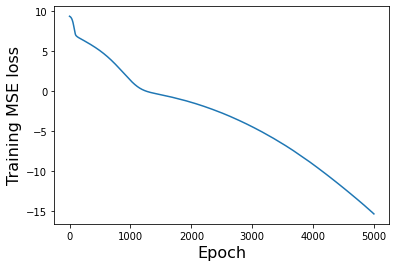

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 5000
lr = 1e-3
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training MSE loss',fontsize=16);
plt.savefig('adam NTK loss.pdf');plt.show()

0 8667.818414567158 8523.353607166377
1 8094.885684007703 9073.91064177898
2 940.2720481093535 996.6847840559931
3 7516.18941382827 8014.523022997857
4 1092.5830922730192 1108.647334367051
5 1814.2020056120177 1647.1889836202288
6 3181.06515099206 3804.87837358223
7 744.7183638319797 727.4207485539096
8 651.1910584893062 625.5018044834494
9 1209.4260882674882 1297.823162148133
10 1104.318782941685 1236.5929054063572
11 659.0507125585865 653.3636774022247
12 3773.8577864666904 3477.6335891484377
13 1080.726628523301 1183.5860174956435
14 434.3124932417453 454.7552610333727
15 254.98819424406173 223.02213689992226
16 306.1379142353365 314.3654719801633
17 282.3842755636953 279.3972361457056
18 260.3259977622004 238.15648210097135
19 196.54892891417148 190.3482669866896
20 114.04095381591345 108.57028188140373
21 187.1453234023519 207.75265493037026
22 174.64261710149705 187.75691050589336
23 277.26155153133453 256.15341249668256
24 104.4074910445354 91.48341312237753
25 120.6659845482329

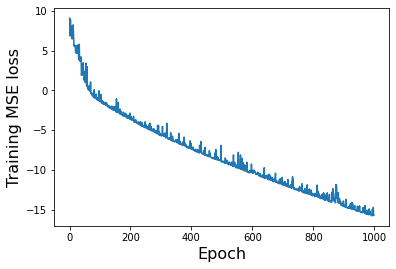

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 1000
lr = 1e-2
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = 8

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training MSE loss',fontsize=16);
plt.savefig('SGD NTK loss.pdf');plt.show()

Streaming output truncated to the last 5000 lines.
5001 66.63145364331598 70.28816230509047
5002 68.65471343665006 72.12184225427292
5003 64.80340894164812 68.43639021381946
5004 66.92005789827981 70.33325849748164
5005 63.27184025106017 66.91323423949564
5006 65.19159088183926 68.58671711240171
5007 61.727998002189885 65.35643171993212
5008 63.50208541063857 66.90796554407054
5009 60.22971060568879 63.84044241777428
5010 62.00785691346722 65.43298811139995
5011 58.928099912342134 62.52515560675184
5012 60.90169826863292 64.27528210436164
5013 57.96823454649188 61.56651459592434
5014 59.97062351521876 63.36800194450439
5015 57.169014421512436 60.7619747014881
5016 58.90436071474324 62.29804524112849
5017 56.21208036515399 59.78052779993744
5018 57.75070907119987 61.13040936473612
5019 55.15220098322328 58.717055643950154
5020 56.66396421480339 60.014490788679616
5021 54.16106054521804 57.72697266284635
5022 55.60804866272166 58.99221428696767
5023 53.24088624005774 56.78623084949432
50

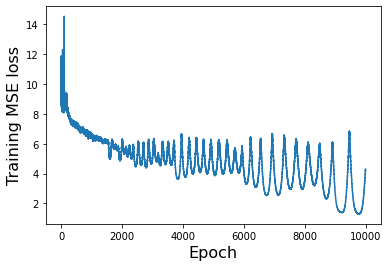

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 10000
lr = 1e-2
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr,nesterov=True,momentum=0.8)
criterion = nn.MSELoss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))

plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training MSE loss',fontsize=16);
plt.savefig('Nesterov NTK loss.pdf');plt.show()

## other loss

In [0]:
sigma, n, p, p1=1, 100, 11, 1
torch.manual_seed(0)
np.random.seed(0)
y_train, X_train, beta1 = setting(n=n, p=p, p1=p1, noise=sigma)
Z_train, T_train = X_train[:, 0].reshape((-1,1)), X_train[:, 1:]
from sklearn import preprocessing
T_train=preprocessing.normalize(T_train, norm='l2')
yZ_train, T_train = newset(y_train, Z_train, T_train)


max_epoch = 100000
lr = 1e-2
D_in, H, D_out = p-p1, 10000, p1+1
batch_size = n

Train_dataset = TensorDataset(T_train, yZ_train)
trainloader = DataLoader(dataset=Train_dataset, batch_size=batch_size, shuffle=True)

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.SmoothL1Loss()
y_loss,Z_loss=[],[]
for epoch in range(max_epoch):
  for batch_T, batch_yZ in trainloader:
    optimizer.zero_grad()
    batch_yZ_pred = model(batch_T)
    batch_loss = criterion(batch_yZ_pred, batch_yZ)
    batch_loss.backward()
    optimizer.step()
  with torch.no_grad():
    yZ_pred = model(T_train).cpu().detach().numpy()
    print(epoch,np.mean((yZ_pred[:,0]-y_train.flatten())**2),np.mean((yZ_pred[:,1]-Z_train.flatten())**2))
    y_loss.append(np.mean((yZ_pred[:,0]-y_train.flatten())**2))
    Z_loss.append(np.mean((yZ_pred[:,1]-Z_train.flatten())**2))



Streaming output truncated to the last 5000 lines.
34572 5.141943565142038 4.610693555069873
34573 4.940597620879662 5.616542409078803
34574 5.1465723706732955 4.61509698187622
34575 4.946460678458186 5.622574057286738
34576 5.1475254250935985 4.615741041552205
34577 4.9412437199422525 5.617038559113936
34578 5.144774797731913 4.613180464193763
34579 4.942241747793505 5.617765910516792
34580 5.144913332111288 4.613492638933481
34581 4.93977550681936 5.615233263171885
34582 5.142827509565501 4.6116523173127035
34583 4.938101477814762 5.613181232758267
34584 5.142063334195423 4.611109994651851
34585 4.937321320623584 5.612148579857322
34586 5.147172189884393 4.61635977172633
34587 4.942727858788956 5.6184641390698395
34588 5.148301109964972 4.616608465776637
34589 4.940496780913766 5.615944441475633
34590 5.146451951753392 4.6154325584989895
34591 4.9392276594705455 5.614620156412631
34592 5.14548849024369 4.615046673666158
34593 4.937595194683471 5.61251560660713
34594 5.14293437967169 

KeyboardInterrupt: ignored

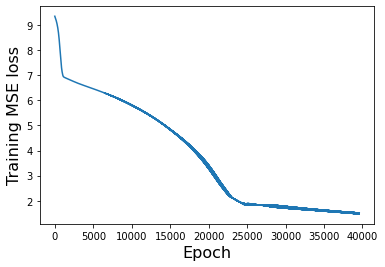

In [0]:
plt.plot(range(len(y_loss)),np.log(y_loss));plt.xlabel('Epoch',fontsize=16);plt.ylabel('Training MSE loss',fontsize=16);
plt.savefig('MAE NTK loss.pdf');plt.show()